In [1]:
# ✅ Install dependencies
%pip install ultralytics opencv-python albumentations
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

import os
import cv2
import glob
import random
import torch
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from ultralytics import YOLO

print("✅ GPU available:", torch.cuda.is_available())
print("🖥️  Current GPU device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

# ✅ Dataset root
DATA_DIR = "E:/Work/KSA/Model1/DatasetV1"
AUG_SPLIT = "train_aug"

Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://download.pytorch.org/whl/cu121
Note: you may need to restart the kernel to use updated packages.
✅ GPU available: True
🖥️  Current GPU device: NVIDIA GeForce RTX 4080 Laptop GPU


In [2]:
# ✅ Define augmentation pipeline
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ToGray(p=0.1),
    A.Affine(scale=(0.9, 1.1), translate_percent=(0.05, 0.05), rotate=(-15, 15), p=0.7),
    A.Blur(p=0.2),
    A.GaussNoise(p=0.2),
    A.HueSaturationValue(p=0.3),
    A.CoarseDropout(
        num_holes_range=(1, 3),
        hole_height_range=(10, 40),
        hole_width_range=(10, 40),
        fill=0,
        p=0.3
    ),
    ToTensorV2()
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

# ✅ Create folders for augmented data
os.makedirs(f"{DATA_DIR}/{AUG_SPLIT}/images", exist_ok=True)
os.makedirs(f"{DATA_DIR}/{AUG_SPLIT}/labels", exist_ok=True)

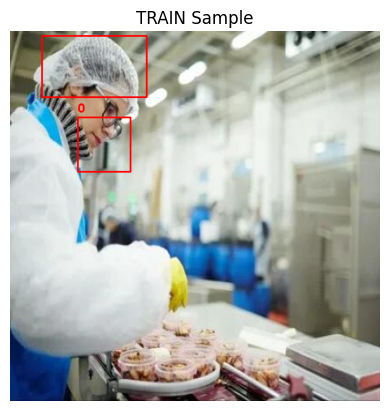

In [3]:
# ✅ Function to show a random sample with bounding boxes
def show_random_sample(split="train"):
    img_path = random.choice(glob.glob(f"{DATA_DIR}/{split}/images/*.jpg"))
    label_path = img_path.replace("images", "labels").replace(".jpg", ".txt")

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                cls, x_center, y_center, w, h = map(float, line.strip().split())
                h_img, w_img = img.shape[:2]
                x_center *= w_img
                y_center *= h_img
                w *= w_img
                h *= h_img
                x1 = int(x_center - w / 2)
                y1 = int(y_center - h / 2)
                x2 = int(x_center + w / 2)
                y2 = int(y_center + h / 2)
                cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
                cv2.putText(img, str(int(cls)), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{split.upper()} Sample")
    plt.show()

# ✅ Display a random sample
show_random_sample("train")

# Class 0: No Mask
# Class 1: No Hairnet
# Class 2: Hairnet
# Class 3: Mask

In [4]:
# ✅ Data augmentation function
def augment_and_save(img_path, label_path, out_split="train_aug", max_augs=3):
    img = cv2.imread(img_path)
    h_img, w_img = img.shape[:2]

    with open(label_path, 'r') as f:
        lines = f.readlines()

    bboxes = []
    class_labels = []
    for line in lines:
        cls, x, y, w, h = map(float, line.strip().split())
        bboxes.append([x, y, w, h])
        class_labels.append(int(cls))

    base_name = os.path.basename(img_path).replace(".jpg", "")

    for i in range(max_augs):
        aug_img_name = f"{base_name}_aug{i}.jpg"
        aug_img_path = os.path.join(DATA_DIR, out_split, "images", aug_img_name)
        aug_label_path = os.path.join(DATA_DIR, out_split, "labels", aug_img_name.replace(".jpg", ".txt"))

        if os.path.exists(aug_img_path):
            continue

        transformed = transform(image=img, bboxes=bboxes, class_labels=class_labels)
        aug_img = transformed['image']
        aug_bboxes = transformed['bboxes']
        aug_labels = transformed['class_labels']

        cv2.imwrite(aug_img_path, aug_img)
        with open(aug_label_path, 'w') as f:
            for cls_id, bbox in zip(aug_labels, aug_bboxes):
                f.write(f"{cls_id} {' '.join(map(str, bbox))}\n")

In [5]:
# ✅ Run augmentation
for split in ["train"]:
    img_paths = glob.glob(f"{DATA_DIR}/{split}/images/*.jpg")
    for img_path in img_paths:
        if "_aug" in os.path.basename(img_path):
            continue
        label_path = img_path.replace("images", "labels").replace(".jpg", ".txt")
        if os.path.exists(label_path):
            augment_and_save(img_path, label_path, out_split=AUG_SPLIT)

print("✅ Augmentation complete.")

✅ Augmentation complete.


In [6]:
# ✅ Load and train YOLOv8m model
model = YOLO('yolov8m.pt')

model.train(
    data=f"{DATA_DIR}/data.yaml",
    epochs=100,                
    imgsz=640,
    batch=8,
    name="mask_hairnet_v1",
    project="E:/Work/KSA/Model1",
    device=0,
    lr0=0.001,                
    optimizer="Adam",        
    conf=0.001,
    iou=0.45,
    box=True,
    cls=True,
    degrees=5,                
    translate=0.1,
    scale=0.5,
    agnostic_nms=False, 
    hsv_h=0.015, hsv_s=0.7, hsv_v=0.4,
)

New https://pypi.org/project/ultralytics/8.3.171 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.169  Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4080 Laptop GPU, 12282MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=True, cache=False, cfg=None, classes=None, close_mosaic=10, cls=True, conf=0.001, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=E:/Work/KSA/Model1/DatasetV1/data.yaml, degrees=5, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.45, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=mask_hairnet_v1, 

train: Scanning E:\Work\KSA\Model1\DatasetV1\train\labels.cache... 107 images, 0 backgrounds, 0 corrupt: 100%|██████████| 107/107 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access  (ping: 0.10.0 ms, read: 411.3135.1 MB/s, size: 45.9 KB)


val: Scanning E:\Work\KSA\Model1\DatasetV1\valid\labels.cache... 10 images, 1 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<?, ?it/s]


Plotting labels to E:\Work\KSA\Model1\mask_hairnet_v1\labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to E:\Work\KSA\Model1\mask_hairnet_v1
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      3.37G     0.3034      8.451      2.206         14        640: 100%|██████████| 14/14 [00:02<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.59it/s]

                   all         10         51      0.132       0.32      0.119     0.0425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      3.52G     0.2745      4.719      1.736         52        640: 100%|██████████| 14/14 [00:01<00:00,  7.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.81it/s]

                   all         10         51      0.449      0.279      0.111     0.0237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      3.52G      0.271          4      1.678         43        640: 100%|██████████| 14/14 [00:01<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.47it/s]

                   all         10         51      0.313      0.514      0.277      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      3.52G     0.2657      3.691       1.65         36        640: 100%|██████████| 14/14 [00:01<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.12it/s]

                   all         10         51      0.356      0.443      0.237     0.0806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      3.52G     0.2616      3.735      1.665         25        640: 100%|██████████| 14/14 [00:01<00:00,  8.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.76it/s]

                   all         10         51      0.471      0.368       0.33      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      3.52G     0.2568      3.581      1.713         34        640: 100%|██████████| 14/14 [00:01<00:00,  8.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]

                   all         10         51      0.525      0.693       0.68      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      3.52G     0.2654      3.263      1.711         24        640: 100%|██████████| 14/14 [00:01<00:00,  8.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.29it/s]

                   all         10         51      0.521      0.719      0.658      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      3.52G     0.2605      3.505      1.787          7        640: 100%|██████████| 14/14 [00:01<00:00,  8.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.25it/s]

                   all         10         51      0.605      0.579      0.622      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      3.52G       0.26      3.268      1.704         14        640: 100%|██████████| 14/14 [00:01<00:00,  9.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.10it/s]

                   all         10         51      0.605       0.56      0.487      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      3.52G      0.266      3.202      1.719         20        640: 100%|██████████| 14/14 [00:01<00:00,  8.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.65it/s]

                   all         10         51      0.755      0.557      0.605      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      3.52G     0.2466      2.993      1.698         12        640: 100%|██████████| 14/14 [00:01<00:00,  8.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.09it/s]

                   all         10         51       0.51      0.722      0.627      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      3.52G      0.248       2.88      1.694         13        640: 100%|██████████| 14/14 [00:01<00:00,  8.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.98it/s]

                   all         10         51      0.704       0.66      0.652      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      3.52G      0.241      2.669      1.662         42        640: 100%|██████████| 14/14 [00:01<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.89it/s]

                   all         10         51       0.69      0.783      0.775      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      3.52G     0.2441      2.616      1.584         27        640: 100%|██████████| 14/14 [00:01<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.57it/s]

                   all         10         51      0.712      0.765      0.793      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      3.52G     0.2522       2.73      1.686         18        640: 100%|██████████| 14/14 [00:01<00:00,  8.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.21it/s]

                   all         10         51      0.668      0.741      0.766       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      3.52G     0.2425      2.578      1.661         14        640: 100%|██████████| 14/14 [00:01<00:00,  8.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.56it/s]

                   all         10         51      0.722      0.687      0.775      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      3.52G     0.2443      2.543      1.637         11        640: 100%|██████████| 14/14 [00:01<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.32it/s]

                   all         10         51      0.674      0.777      0.788      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      3.52G     0.2388      2.544       1.59         35        640: 100%|██████████| 14/14 [00:01<00:00,  8.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.11it/s]

                   all         10         51      0.665      0.791      0.796      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      3.52G     0.2426      2.681      1.654          3        640: 100%|██████████| 14/14 [00:01<00:00,  8.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.34it/s]

                   all         10         51      0.697      0.823      0.806      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      3.52G     0.2424      2.389      1.606         19        640: 100%|██████████| 14/14 [00:01<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.77it/s]

                   all         10         51      0.677      0.732      0.771      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      3.52G     0.2408      2.331      1.604         47        640: 100%|██████████| 14/14 [00:01<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.37it/s]

                   all         10         51      0.618      0.753      0.702      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      3.52G     0.2286      2.295       1.57         24        640: 100%|██████████| 14/14 [00:01<00:00,  8.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.23it/s]

                   all         10         51      0.769      0.538      0.655      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      3.52G     0.2267      2.156      1.562         17        640: 100%|██████████| 14/14 [00:01<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.31it/s]

                   all         10         51      0.628      0.582      0.619      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      3.52G     0.2358      2.224      1.579         41        640: 100%|██████████| 14/14 [00:01<00:00,  8.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.63it/s]

                   all         10         51      0.512      0.588      0.562      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      3.52G     0.2374      2.321      1.572          8        640: 100%|██████████| 14/14 [00:01<00:00,  8.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.70it/s]

                   all         10         51      0.804       0.65      0.714      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      3.52G      0.241      2.185      1.623         19        640: 100%|██████████| 14/14 [00:01<00:00,  8.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.80it/s]

                   all         10         51      0.674      0.765      0.753      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      3.52G     0.2318      2.097      1.593         20        640: 100%|██████████| 14/14 [00:01<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.48it/s]

                   all         10         51      0.828      0.752      0.809      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      3.52G     0.2259      2.147      1.633         36        640: 100%|██████████| 14/14 [00:01<00:00,  8.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.57it/s]

                   all         10         51      0.908      0.685      0.776      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      3.52G     0.2312       2.13      1.561         26        640: 100%|██████████| 14/14 [00:01<00:00,  8.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.38it/s]

                   all         10         51      0.697      0.721      0.737      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      3.52G     0.2213      1.977      1.543         14        640: 100%|██████████| 14/14 [00:01<00:00,  8.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.02it/s]

                   all         10         51      0.744      0.687      0.712      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      3.52G     0.2282      2.014      1.524         31        640: 100%|██████████| 14/14 [00:01<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.25it/s]

                   all         10         51      0.763      0.679      0.709      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      3.52G     0.2261      2.069      1.611         15        640: 100%|██████████| 14/14 [00:01<00:00,  8.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.60it/s]

                   all         10         51      0.776      0.777      0.782      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      3.52G     0.2188      1.939        1.5         22        640: 100%|██████████| 14/14 [00:01<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.26it/s]

                   all         10         51      0.744      0.632      0.692      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      3.52G     0.2153      1.917      1.549         13        640: 100%|██████████| 14/14 [00:01<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.27it/s]

                   all         10         51      0.696       0.77      0.769        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      3.52G     0.2125      1.968      1.547         14        640: 100%|██████████| 14/14 [00:01<00:00,  8.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.67it/s]

                   all         10         51      0.795       0.83      0.826      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      3.52G     0.2158      1.901      1.523         23        640: 100%|██████████| 14/14 [00:01<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.26it/s]

                   all         10         51      0.782      0.803      0.801      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      3.52G     0.2146      1.947      1.476         22        640: 100%|██████████| 14/14 [00:01<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.09it/s]

                   all         10         51      0.632      0.713      0.667      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      3.52G     0.2175      1.916      1.568         18        640: 100%|██████████| 14/14 [00:01<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.99it/s]

                   all         10         51      0.687      0.695      0.664      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      3.52G     0.2103      1.794      1.445         24        640: 100%|██████████| 14/14 [00:01<00:00,  8.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.50it/s]

                   all         10         51      0.684      0.727      0.672      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      3.52G     0.2125        1.8      1.445         25        640: 100%|██████████| 14/14 [00:01<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.86it/s]

                   all         10         51      0.854      0.618      0.757      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      3.52G     0.2066      1.692      1.412         24        640: 100%|██████████| 14/14 [00:01<00:00,  8.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.12it/s]

                   all         10         51      0.818      0.784      0.805      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      3.52G     0.2036      1.698      1.426         34        640: 100%|██████████| 14/14 [00:01<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.72it/s]

                   all         10         51      0.766      0.765      0.754      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      3.52G     0.2018      1.734       1.46         27        640: 100%|██████████| 14/14 [00:01<00:00,  8.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.98it/s]

                   all         10         51      0.747      0.728      0.749       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      3.52G     0.1958      1.637       1.42         22        640: 100%|██████████| 14/14 [00:01<00:00,  8.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.03it/s]

                   all         10         51      0.796      0.761      0.777      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      3.52G     0.1969      1.561      1.367         14        640: 100%|██████████| 14/14 [00:01<00:00,  8.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.58it/s]

                   all         10         51      0.781      0.795      0.815      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      3.52G     0.1997        1.6      1.409         29        640: 100%|██████████| 14/14 [00:01<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.15it/s]

                   all         10         51      0.815      0.818      0.814       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      3.52G     0.1922      1.522      1.371         32        640: 100%|██████████| 14/14 [00:01<00:00,  8.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.54it/s]

                   all         10         51      0.824      0.817      0.817       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      3.52G     0.1836      1.562      1.411         10        640: 100%|██████████| 14/14 [00:01<00:00,  8.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.01it/s]

                   all         10         51      0.797      0.801      0.767      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      3.52G     0.1918      1.532      1.419         14        640: 100%|██████████| 14/14 [00:01<00:00,  8.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.13it/s]

                   all         10         51      0.832      0.847      0.845       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      3.52G     0.1963       1.66      1.496         11        640: 100%|██████████| 14/14 [00:01<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.55it/s]

                   all         10         51      0.853      0.828      0.848      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      3.52G     0.1876      1.706      1.456         12        640: 100%|██████████| 14/14 [00:01<00:00,  8.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.65it/s]

                   all         10         51      0.834      0.809      0.831      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      3.52G     0.1917      1.589      1.394         27        640: 100%|██████████| 14/14 [00:01<00:00,  8.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.56it/s]

                   all         10         51      0.771      0.753      0.766      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      3.52G     0.1867      1.478      1.355         24        640: 100%|██████████| 14/14 [00:01<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.94it/s]

                   all         10         51      0.726      0.648      0.665      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      3.52G     0.1886      1.553      1.414         14        640: 100%|██████████| 14/14 [00:01<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.23it/s]

                   all         10         51      0.733      0.721       0.73      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      3.52G     0.1759      1.473      1.339         35        640: 100%|██████████| 14/14 [00:01<00:00,  8.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.63it/s]

                   all         10         51      0.725       0.68      0.688      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      3.52G      0.187      1.532      1.366         24        640: 100%|██████████| 14/14 [00:01<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.36it/s]

                   all         10         51      0.838      0.668      0.729      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      3.52G     0.1823      1.515      1.422         12        640: 100%|██████████| 14/14 [00:01<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.98it/s]

                   all         10         51      0.759      0.736      0.718      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      3.52G     0.1728      1.444      1.294         30        640: 100%|██████████| 14/14 [00:01<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.02it/s]

                   all         10         51      0.869      0.795      0.841      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      3.52G     0.1747      1.515      1.361          4        640: 100%|██████████| 14/14 [00:01<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.09it/s]

                   all         10         51      0.844      0.799      0.838      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      3.52G     0.1737      1.444      1.393         12        640: 100%|██████████| 14/14 [00:01<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.95it/s]

                   all         10         51      0.829      0.803      0.829      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      3.52G      0.174      1.419      1.354         19        640: 100%|██████████| 14/14 [00:01<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.68it/s]

                   all         10         51      0.845      0.802      0.832      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      3.52G      0.168      1.364      1.305         23        640: 100%|██████████| 14/14 [00:01<00:00,  8.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.59it/s]

                   all         10         51      0.874      0.808      0.852      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      3.52G      0.172      1.337      1.294         35        640: 100%|██████████| 14/14 [00:01<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.16it/s]

                   all         10         51      0.896        0.8      0.851      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      3.52G      0.166      1.359      1.299         41        640: 100%|██████████| 14/14 [00:01<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.86it/s]

                   all         10         51      0.863       0.78      0.843      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      3.52G     0.1661      1.296      1.319          9        640: 100%|██████████| 14/14 [00:01<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.99it/s]

                   all         10         51      0.841      0.779       0.83      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      3.52G     0.1667      1.304      1.302         19        640: 100%|██████████| 14/14 [00:01<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.23it/s]

                   all         10         51       0.88      0.805      0.827      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      3.52G     0.1611      1.258      1.235         41        640: 100%|██████████| 14/14 [00:01<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.35it/s]

                   all         10         51       0.89      0.809      0.822      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      3.52G     0.1592      1.323      1.308         17        640: 100%|██████████| 14/14 [00:01<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.69it/s]

                   all         10         51      0.844      0.817      0.839      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      3.52G     0.1601      1.323      1.278         13        640: 100%|██████████| 14/14 [00:01<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.45it/s]

                   all         10         51      0.808      0.796      0.786      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      3.52G      0.164      1.415      1.352         42        640: 100%|██████████| 14/14 [00:01<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.02it/s]

                   all         10         51       0.85      0.795      0.825      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      3.52G     0.1615      1.328      1.317         16        640: 100%|██████████| 14/14 [00:01<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.03it/s]

                   all         10         51      0.812      0.822       0.82      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      3.52G      0.157       1.27      1.243         22        640: 100%|██████████| 14/14 [00:01<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.08it/s]

                   all         10         51      0.868      0.807      0.847       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      3.52G     0.1471      1.255      1.201         46        640: 100%|██████████| 14/14 [00:01<00:00,  8.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.08it/s]

                   all         10         51      0.829      0.785      0.803      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      3.52G     0.1562      1.293      1.249         12        640: 100%|██████████| 14/14 [00:01<00:00,  8.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.08it/s]

                   all         10         51      0.835      0.822      0.808      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      3.52G     0.1506      1.199      1.197         21        640: 100%|██████████| 14/14 [00:01<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.58it/s]

                   all         10         51      0.816      0.807      0.787      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      3.52G     0.1546      1.269      1.286         25        640: 100%|██████████| 14/14 [00:01<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.52it/s]

                   all         10         51      0.882        0.8      0.834      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      3.52G     0.1502      1.197      1.231         11        640: 100%|██████████| 14/14 [00:01<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.68it/s]

                   all         10         51      0.795      0.782      0.774      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      3.52G     0.1512      1.265      1.251         17        640: 100%|██████████| 14/14 [00:01<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.53it/s]

                   all         10         51       0.88      0.745      0.774      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      3.52G     0.1462      1.158      1.223         12        640: 100%|██████████| 14/14 [00:01<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.11it/s]

                   all         10         51      0.821       0.77      0.774      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      3.52G     0.1438      1.168       1.24         19        640: 100%|██████████| 14/14 [00:01<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.30it/s]

                   all         10         51      0.873      0.809      0.839      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      3.52G     0.1364      1.066      1.166         17        640: 100%|██████████| 14/14 [00:01<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.10it/s]

                   all         10         51      0.871      0.809      0.811      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      3.52G     0.1418      1.171      1.202         13        640: 100%|██████████| 14/14 [00:01<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.29it/s]

                   all         10         51      0.885      0.744       0.76      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      3.52G     0.1366      1.124      1.155          9        640: 100%|██████████| 14/14 [00:01<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.85it/s]

                   all         10         51      0.859       0.75      0.768      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      3.52G      0.138      1.149      1.195         20        640: 100%|██████████| 14/14 [00:01<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.07it/s]

                   all         10         51      0.856      0.765      0.774      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      3.52G     0.1402      1.156      1.204         35        640: 100%|██████████| 14/14 [00:01<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]

                   all         10         51      0.909      0.753      0.847      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      3.52G     0.1399      1.146      1.203         14        640: 100%|██████████| 14/14 [00:01<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]

                   all         10         51        0.8      0.724      0.733      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      3.52G     0.1385      1.109      1.189         20        640: 100%|██████████| 14/14 [00:01<00:00,  8.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.54it/s]

                   all         10         51      0.798      0.725      0.734      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      3.52G     0.1292      1.053      1.145         11        640: 100%|██████████| 14/14 [00:01<00:00,  8.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.79it/s]

                   all         10         51      0.789      0.727      0.729       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      3.52G     0.1347      1.088      1.161         59        640: 100%|██████████| 14/14 [00:01<00:00,  8.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.37it/s]

                   all         10         51      0.762      0.805      0.772      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      3.52G     0.1345      1.107      1.172         12        640: 100%|██████████| 14/14 [00:01<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.55it/s]

                   all         10         51      0.846      0.758      0.766      0.334


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      3.52G     0.1296      1.005       1.17         10        640: 100%|██████████| 14/14 [00:01<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.65it/s]

                   all         10         51       0.85      0.752      0.766      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      3.52G      0.127     0.9764      1.136          8        640: 100%|██████████| 14/14 [00:01<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.27it/s]

                   all         10         51      0.857      0.752       0.78      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      3.52G     0.1308     0.9668       1.18          8        640: 100%|██████████| 14/14 [00:01<00:00,  8.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.64it/s]

                   all         10         51      0.742       0.79      0.751      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      3.52G     0.1273     0.9953      1.139         22        640: 100%|██████████| 14/14 [00:01<00:00,  8.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.00it/s]

                   all         10         51      0.803      0.781      0.791      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      3.52G     0.1262     0.9475      1.152         18        640: 100%|██████████| 14/14 [00:01<00:00,  8.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.99it/s]

                   all         10         51      0.793      0.777      0.796       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      3.52G     0.1248     0.9191      1.152          8        640: 100%|██████████| 14/14 [00:01<00:00,  8.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.94it/s]

                   all         10         51      0.776      0.776      0.809      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      3.52G     0.1211     0.9272      1.133         27        640: 100%|██████████| 14/14 [00:01<00:00,  8.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.22it/s]

                   all         10         51      0.888      0.706      0.823      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      3.52G     0.1206     0.9188      1.114         18        640: 100%|██████████| 14/14 [00:01<00:00,  8.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.35it/s]

                   all         10         51      0.888      0.706      0.834      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      3.52G     0.1129     0.8781      1.088         13        640: 100%|██████████| 14/14 [00:01<00:00,  8.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.97it/s]

                   all         10         51      0.744      0.834      0.836      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      3.52G     0.1197     0.8909      1.098          6        640: 100%|██████████| 14/14 [00:01<00:00,  8.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.52it/s]

                   all         10         51      0.745      0.832      0.832      0.323



100 epochs completed in 0.070 hours.
Optimizer stripped from E:\Work\KSA\Model1\mask_hairnet_v1\weights\last.pt, 52.0MB
Optimizer stripped from E:\Work\KSA\Model1\mask_hairnet_v1\weights\best.pt, 52.0MB

Validating E:\Work\KSA\Model1\mask_hairnet_v1\weights\best.pt...
Ultralytics 8.3.169  Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4080 Laptop GPU, 12282MiB)
Model summary (fused): 92 layers, 25,842,076 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.54it/s]


                   all         10         51        0.9        0.8      0.851      0.369
               NO mask          5          6      0.945          1      0.995      0.342
             NOhairnet          2         13      0.808      0.651      0.725      0.274
               hairnet          8         14      0.899      0.714      0.811      0.361
                  mask          4         18      0.947      0.833      0.873      0.498
Speed: 0.1ms preprocess, 3.5ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to E:\Work\KSA\Model1\mask_hairnet_v1


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001F6D96128F0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
       

In [7]:
# ✅ Export to ONNX
trained_model = YOLO("E:/Work/KSA/Model1/mask_hairnet_v1/weights/best.pt")
trained_model.export(format="onnx", dynamic=False, simplify=True, opset=12)
print("✅ Model exported to ONNX.")

Ultralytics 8.3.169  Python-3.10.18 torch-2.5.1+cu121 CPU (13th Gen Intel Core(TM) i9-13900HX)
 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/
Model summary (fused): 92 layers, 25,842,076 parameters, 0 gradients, 78.7 GFLOPs

PyTorch: starting from 'E:\Work\KSA\Model1\mask_hairnet_v1\weights\best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 8, 8400) (49.6 MB)

ONNX: starting export with onnx 1.17.0 opset 12...
ONNX: slimming with onnxslim 0.1.61...
ONNX: export success  2.4s, saved as 'E:\Work\KSA\Model1\mask_hairnet_v1\weights\best.onnx' (98.7 MB)

Export complete (3.3s)
Results saved to E:\Work\KSA\Model1\mask_hairnet_v1\weights
Predict:         yolo predict task=detect model=E:\Work\KSA\Model1\mask_hairnet_v1\weights\best.onnx imgsz=640  
Validate:        yolo val task=detect model=E:\Work\KSA\Model1\mask_hairnet_v1\weights\best.onnx imgsz=640 data=E:/Work/KSA/Model1/Da